# 聚类算法

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('seaborn')

## KMeans算法

### 数据准备

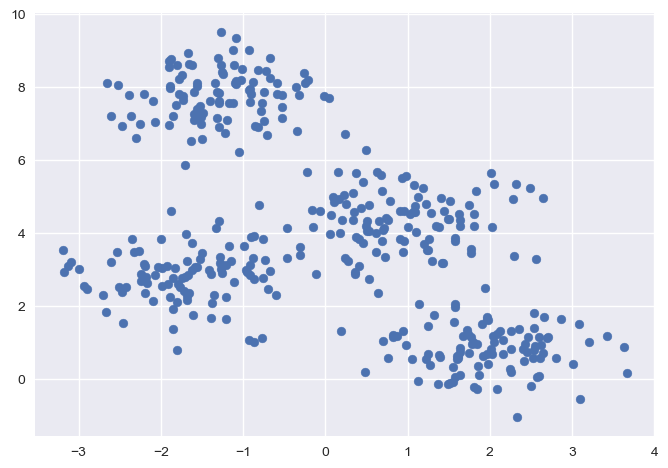

In [3]:
from sklearn.datasets import _samples_generator

X, y_true = _samples_generator.make_blobs(n_samples=400, centers=4,
                                          cluster_std=0.7, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=40)

### 聚类过程可视化演示

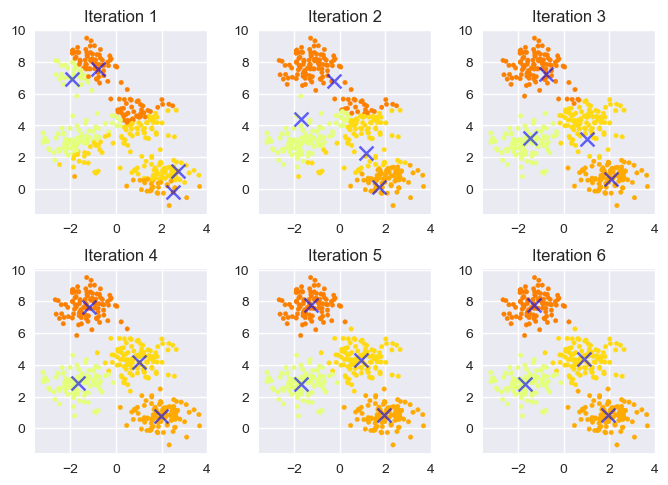

In [4]:
from sklearn.metrics import pairwise_distances_argmin

class MyKMeans:
    def __init__(self, n_clusters, random_state=0):
        self.__n_clusters = n_clusters
        self.__random_state = random_state
    
    def fit_visualize(self, X):
        n = 0
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        centers = X[
            np.random.RandomState(self.__random_state)
                .permutation(X.shape[0])
                [:self.__n_clusters]
        ]
        while True:
            labels = pairwise_distances_argmin(X, centers)
            
            n += 1
            if n <= 6:
                plt.subplot(2, 3, n)
                plt.scatter(X[:, 0], X[:, 1], c=labels,
                            s=10, cmap='Wistia')
                plt.scatter(centers[:, 0], centers[:, 1], 
                            marker='x', s=100, c='b', alpha=0.6)
                plt.title(f'Iteration {n}')
                
            new_centers = np.array([X[labels == i].mean(0)
                                    for i in range(self.__n_clusters)])
            if np.all(centers == new_centers):
                break
            centers = new_centers
        return centers, labels
    
    def fit(self, X):
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        # 随机选择簇中心点
        centers = X[
            np.random.RandomState(self.__random_state)
                .permutation(X.shape[0])
                [:self.__n_clusters]
        ]
        while True:
            # 基于最近的中心指定标签
            labels = pairwise_distances_argmin(X, centers)
            # 根据点的平均值找到新的中心
            new_centers = np.array([X[labels == i].mean(0)
                                    for i in range(self.__n_clusters)])
            # 确认收敛
            if np.all(centers == new_centers):
                break
            centers = new_centers
        return centers, labels
    
centers, labels = MyKMeans(4).fit_visualize(X)


### KMeans模型建立

数据准备

`X.shape` should be like `(n_samples, n_features)`

In [5]:
X, y_true = _samples_generator.make_blobs(n_samples=500, centers=7,
                                                        cluster_std=0.7, random_state=0)
X.shape

(500, 2)

模型建立

In [6]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=7)
cluster.fit(X)

KMeans(n_clusters=7)

结果展示

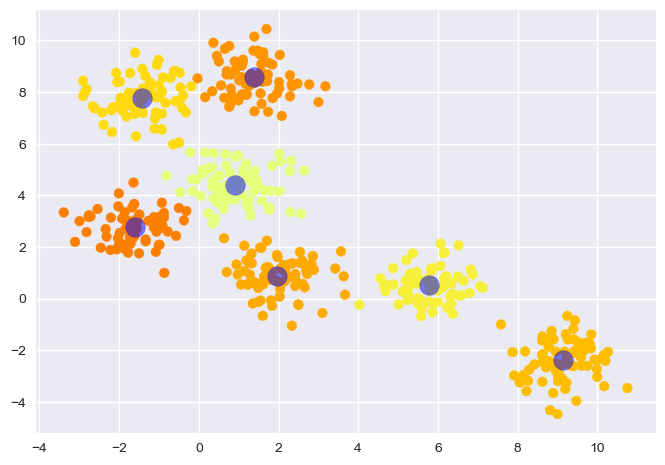

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=cluster.labels_, cmap='Wistia')
centers = cluster.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='b', s=200, alpha=0.5)
pass

### KMeans 结果分析

随机初始点可能带来不好的收敛结果

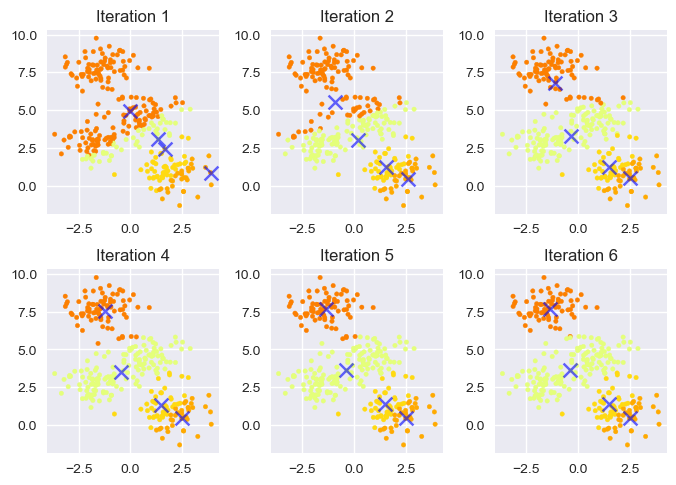

In [8]:
X, y_true = _samples_generator.make_blobs(n_samples=300, centers=4,
                                          cluster_std=0.8, random_state=0)

def find_bad_seed(kct=np.arange(100, 500)):
    wss = np.empty_like(kct, dtype=np.float_)
    for i in kct:
        cluster = MyKMeans(n_clusters=4, random_state=i)
        centers, labels = cluster.fit(X)
        wss[i - kct[0]] = ((X - centers[labels]) ** 2).sum()

    bad_rand_seed = np.where(wss == np.max(wss))[0][0] + kct[0]
    print(f'{bad_rand_seed=}')  # bad_rand_seed=418

cluster = MyKMeans(n_clusters=4, random_state=418)
centers, labels = cluster.fit_visualize(X)

WSS 值：评价 KMeans 模型的方法

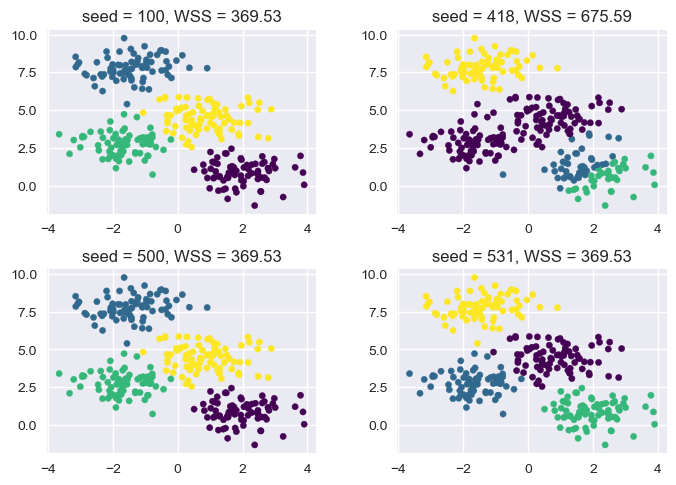

In [9]:
kct = np.array([100, 418, 500, 531])
X, y_true = _samples_generator.make_blobs(n_samples=300, centers=4,
                                          cluster_std=0.8, random_state=0)
for i, k in enumerate(kct):
    cluster = MyKMeans(n_clusters=4, random_state=k)
    centers, labels = cluster.fit(X)
    wss = ((X - centers[labels]) ** 2).sum()
    plt.subplot(2, 2, i + 1)
    plt.title(f'seed = {k}, WSS = {wss:.2f}')
    plt.scatter(X[:, 0], X[:, 1], s=20, c=labels, cmap='viridis')

使用 *`n_init`* 参数多次收敛取最好结果，默认值为 10

In [10]:
cluster = KMeans(n_clusters=4)
cluster.fit(X)
cluster.score(X)

-369.52798550013665

该聚合成几类？

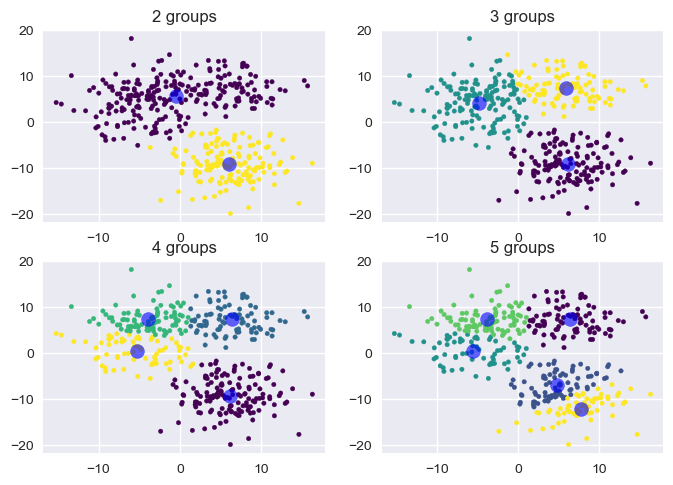

In [11]:
X1, y_true = _samples_generator.make_blobs(n_samples=200, centers=4,
                                          cluster_std=3, random_state=2423)
X2, y_true = _samples_generator.make_blobs(n_samples=200, centers=2,
                                          cluster_std=4, random_state=52)
X = np.concatenate((X1, X2))

for k in range(2, 6):
    plt.subplot(2, 2, k - 1)
    plt.title(f'{k} groups')
    cluster = KMeans(n_clusters=k)
    cluster.fit(X)
    plt.scatter(X[:, 0], X[:, 1],
                s=10, c=cluster.labels_, cmap='viridis')

    centers = cluster.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], s=100, c='b', alpha=0.6)


检查各个聚类数的 WSS 值，并根据肘部计算最好的结果

best_k=3


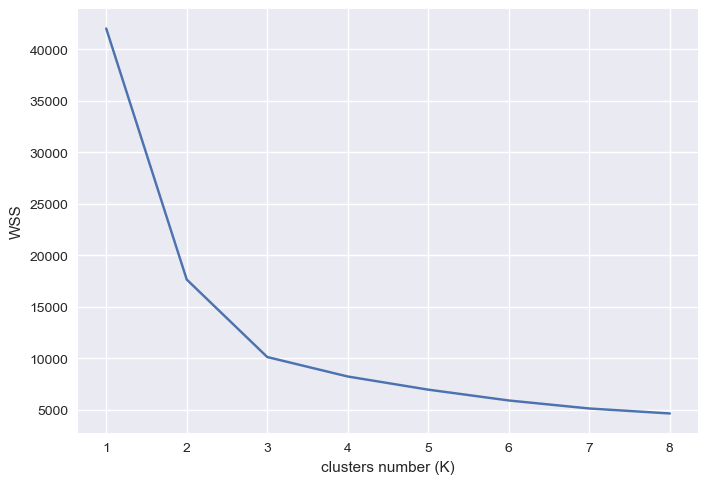

In [12]:
kct = np.arange(1, 9)
wss = np.empty_like(kct, dtype=object)

for i, k in enumerate(kct):
    cluster = KMeans(n_clusters=k)
    cluster.fit(X)
    wss[i] = cluster.inertia_

slope = (wss[0] - wss[-1]) / (kct[0] - kct[-1])
intercept = wss[0] - slope * kct[0]
y = kct * slope + intercept

best_k = kct[(y - wss).argmax()]

plt.plot(kct, wss)
plt.xlabel('clusters number (K)')
plt.ylabel('WSS')

print(f'{best_k=}')

使用轮廓系数判断最好结果：

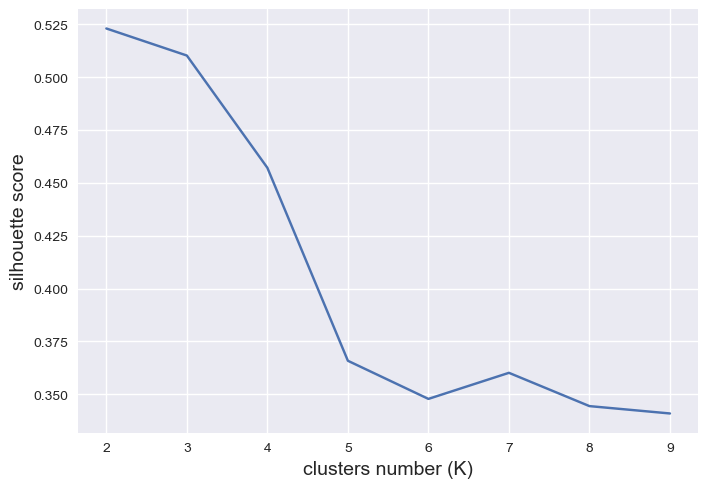

In [13]:
from sklearn.metrics import silhouette_score

kct = np.arange(2, 10)
ssc = np.empty_like(kct, dtype=np.float_)

for i, k in enumerate(kct):
    cluster = KMeans(n_clusters=k)
    cluster.fit(X)
    ssc[i] = silhouette_score(X, cluster.labels_)

plt.plot(kct, ssc)
plt.xlabel('clusters number (K)', fontsize=14)
plt.ylabel('silhouette score', fontsize=14)
pass

`MiniBatchKMeans` ：利用随机抽样加速大批数据

In [14]:
from sklearn.cluster import MiniBatchKMeans

X, y_true = _samples_generator.make_blobs(n_samples=100000, centers=12,
                                          cluster_std=0.8, random_state=0)

In [15]:
%%timeit
cluster = KMeans(n_clusters=12)
cluster.fit(X)

700 ms ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
cluster.score(X)

-1728626.1515711634

In [17]:
%%timeit
cluster = MiniBatchKMeans(n_clusters=12)
cluster.fit(X)

The slowest run took 6.19 times longer than the fastest. This could mean that an intermediate result is being cached.
445 ms ± 269 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
cluster.score(X)

-1728626.1515711634

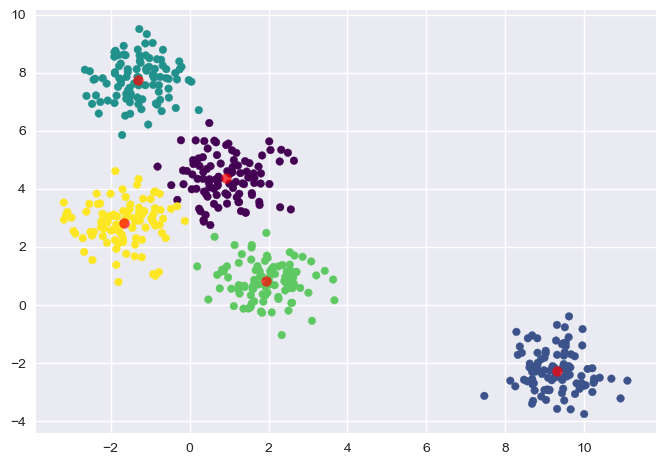

In [19]:
# useless
__X, __y_true = _samples_generator.make_blobs(n_samples=500, centers=5,
                                          cluster_std=0.7, random_state=0)
__cluster = KMeans(n_clusters=5)
__cluster.fit(__X)
plt.scatter(__X[:, 0], __X[:, 1], s=30, c=__cluster.labels_, cmap='viridis')
__centers = __cluster.cluster_centers_
plt.scatter(__centers[:, 0], __centers[:, 1], s=50, c='r', alpha=0.7)

## DBSCAN 算法

Kmeans 的不足：对复杂形状的聚类结果不好

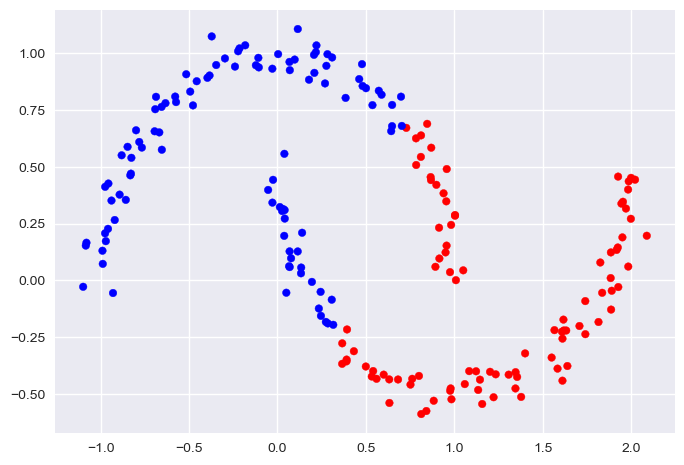

In [20]:
X, y_true = _samples_generator.make_moons(n_samples=200, noise=0.05)
cluster = KMeans(n_clusters=2)
cluster.fit(X)
plt.scatter(X[:, 0], X[:, 1], 
            s=30, c=cluster.labels_, cmap='bwr')

### 使用 DBSCAN 聚类算法

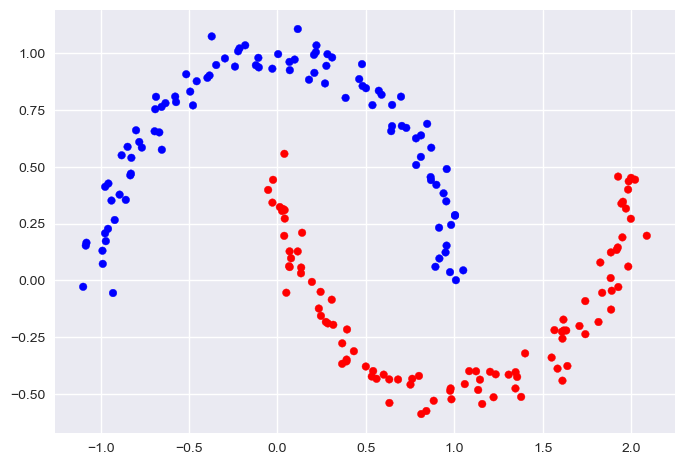

In [21]:
from sklearn.cluster import DBSCAN

cluster = DBSCAN(eps=0.2, min_samples=5)
cluster.fit(X)
plt.scatter(X[:, 0], X[:, 1], 
            s=30, c=cluster.labels_, cmap='bwr')

DBSCAN 算法的直观描述

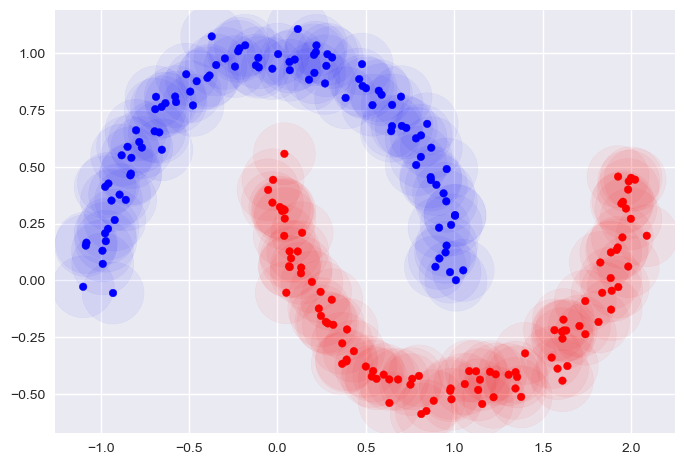

In [22]:
plt.scatter(X[:, 0], X[:, 1], 
            s=30, c=cluster.labels_, cmap='bwr')
plt.scatter(X[:, 0], X[:, 1], 
            s=2000, c=cluster.labels_, cmap='bwr', alpha=0.05)

DBSCAN 算法能识别噪点

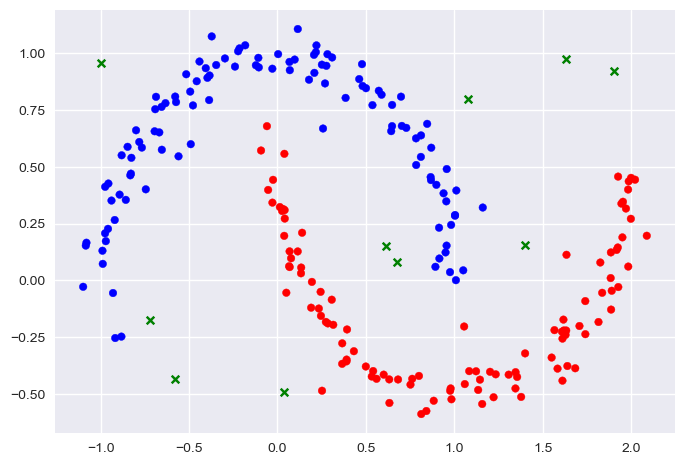

In [23]:
X_noise_x = np.random.RandomState(1).random((30, 1)) * 3 - 1
X_noise_y = np.random.RandomState(4).random((30, 1)) * 1.5 - 0.5
X_noise = np.concatenate([X_noise_x, X_noise_y], axis=1)
X = np.concatenate([X_noise, X])

cluster = DBSCAN(eps=0.2, min_samples=5)
cluster.fit(X)
plt.scatter(X[:, 0][cluster.labels_ != -1], X[:, 1][cluster.labels_ != -1], 
            s=30, c=cluster.labels_[cluster.labels_ != -1], cmap='bwr')
plt.scatter(X[:, 0][cluster.labels_ == -1], X[:, 1][cluster.labels_ == -1], 
            s=30, c='g', marker='x')

DBSCAN 算法的迭代过程演示

C:\Users\Hello\AppData\Local\Temp\ipykernel_61112\3398244850.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 3, __subplot_n)


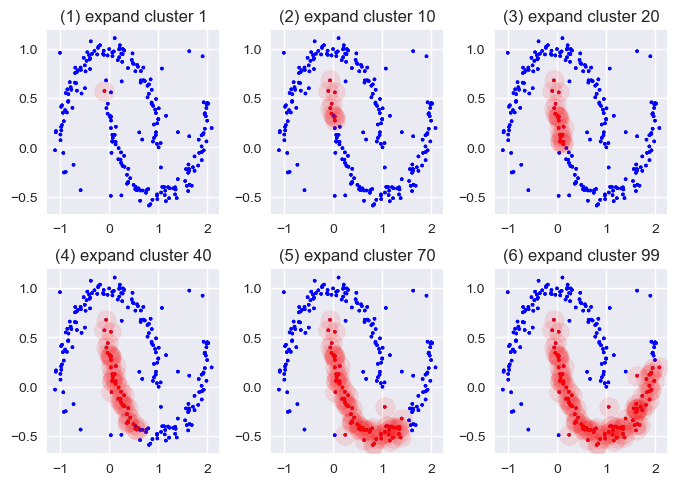

In [24]:
class MyDBSCAN:
    """ A simple Density-Based Spatial Clustering of Applications with Noise(DBSCAN) implement
    see https://github.com/DEEPI-LAB/dbscan-python
    """
    def __init__(self, eps, min_samples):
        self.__eps = eps
        self.__min_samples = min_samples

    def fit(self, X):
        # The number of input dataset
        self.__n_samples = X.shape[0]
        # Euclidean distance
        p, q = np.meshgrid(np.arange(self.__n_samples), 
                           np.arange(self.__n_samples))
        self.__distances = np.sqrt(np.sum(((X[p] - X[q]) ** 2), 2))
        # label as visited points and noise
        self.__visited = np.full((self.__n_samples), False)
        self.__noise = np.full((self.__n_samples), False)
        self.labels_ = np.full((self.__n_samples), 0)
        self.__c = 0
        self._input = X
        
        # Clustering
        for i in range(len(self._input)):
            if self.__visited[i] == False:
                self.__visited[i] = True
                self.__neighbors = self.__region_query(i)
                if len(self.__neighbors) >= self.__min_samples:
                    self.__expand_cluster(i)
                    self.__c += 1
                else: 
                    self.__noise[i] = True     
            
        return self.labels_, self.__noise

    def __region_query(self, i):
        g = self.__distances[i,:] < self.__eps
        neighbors = np.where(g)[0].tolist()
        return neighbors

    def __expand_cluster(self, i):
        self.labels_[i] = self.__c
        k = 0
        
        __iter_n = __subplot_n = 0
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        
        while len(self.__neighbors) > k:
            j = self.__neighbors[k]
            if self.__visited[j] != True:
                self.__visited[j] = True

                neighbors2 = self.__region_query(j)
                v = [neighbors2[i] for i in np.where(self.labels_[neighbors2] == 0)[0]]

                if len(neighbors2) >= self.__min_samples:
                    self.__neighbors = self.__neighbors + v

                __iter_n += 1
                if __iter_n in (1, 10, 20, 40, 70, 99):
                    __subplot_n += 1
                    plt.subplot(2, 3, __subplot_n)
                    plt.title(f'({__subplot_n}) expand cluster {__iter_n}')
                    plt.scatter(self._input[:, 0], self._input[:, 1],
                                s=5, c=self.labels_, cmap='bwr')   
                    plt.scatter(self._input[:, 0][self.labels_ != 0], self._input[:, 1][self.labels_ != 0],
                                s=200, c='red', alpha=0.1)   

            if self.labels_[j] == 0: 
                self.labels_[j] = self.__c
            k += 1


cluster = MyDBSCAN(eps=0.2, min_samples=5)
cluster.fit(X)
# plt.scatter(X[:, 0], X[:, 1], 
#             s=30, c=cluster.labels_, cmap='bwr')
pass

### DBSCAN算法的参数选择

In [25]:
X, y_true = _samples_generator.make_moons(n_samples=200, noise=0.05)
X_noise = np.concatenate(
    [np.random.RandomState(1).random((30, 1)) * 3 - 1, 
     np.random.RandomState(4).random((30, 1)) * 1.5 - 0.5], axis=1)
X = np.concatenate([X_noise, X])
X *= 10

`min_samples` 的选择原则：

$$ \text{min samples} \geq \text{dimensions} + 1 $$

使用 K-距离判断最好 `esp`

Text(0, 0.5, 'K distance')

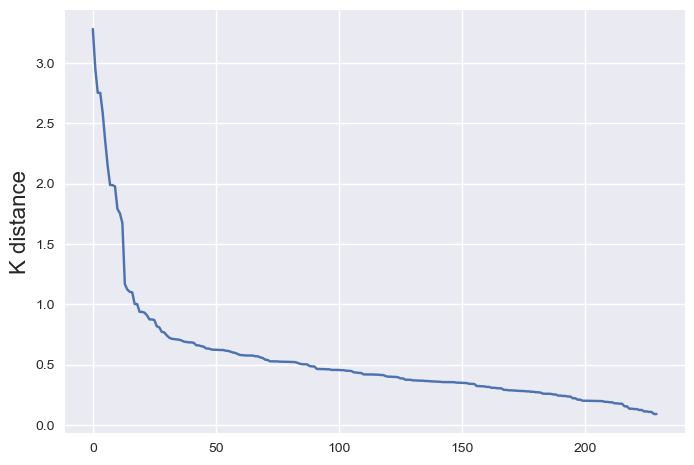

In [26]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

# plt.xlim(450, -50)
plt.plot(distances[::-1])
plt.ylabel('K distance', fontsize=16)

In [27]:
_slope = (distances[::-1][0] - distances[::-1][-1]) /                      \
         (np.arange(len(distances))[0] - np.arange(len(distances))[-1])
_intercept = distances[::-1][0] - _slope * np.arange(len(distances))[0]
_y = np.arange(len(distances)) * _slope + _intercept

best_esp = distances[::-1][(_y - distances[::-1]).argmax()]
print(f'{best_esp=}')

best_esp=0.7237462123161329


不过这种方法不咋可靠，这也是 DBSCAN 算法的缺点

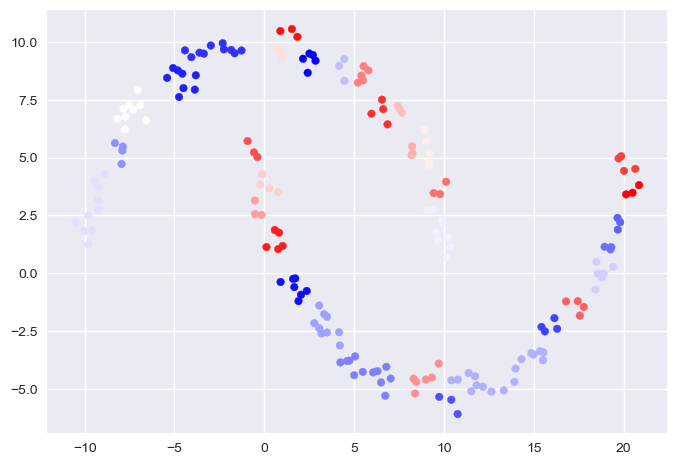

In [28]:
cluster = DBSCAN(eps=best_esp, min_samples=3)
cluster.fit(X)
plt.scatter(X[:, 0][cluster.labels_ != -1], X[:, 1][cluster.labels_ != -1], 
            s=30, c=cluster.labels_[cluster.labels_ != -1], cmap='bwr')